# scPRAM: a landmark perturbation model for unseen conditions
---
----------------------------------------


## 1. Introduction

This notebook is the **sister-tutorial to our scGen notebook** and shows how [scPRAM](https://github.com/jiang-q19/scPRAM) (single-cell Perturbation-Response Analysis Model) tackles exactly the same questions, but with an **attention-driven, optimal-transport twist**. By mirroring the structure and visual language of the scGen notebook you can compare the two models side-by-side, reuse the evaluation code, and build an intuition for where their design choices diverge.

In this notebook we will:
1. Load and prepare the *Kang 2018* PBMC dataset like before.
2. Train the scPRAM model to predict unseen perturbations.
3. Generate and visualise in-silico predictions.
4. Benchmark results on CD4 T cells with statistical and biological metrics.
5. Rerun scPRAM for each cell type in the dataset.
6. Explore the attention scores of the model.
7. Perform cross-study extrapolation.

----------------------------------------
## 2. Environment Setup and Import

In [60]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)
import warnings           # warning control (e.g. to suppress scVI warnings)
warnings.filterwarnings('ignore')  # suppress warnings (e.g. from scanpy)

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.stats import energy_distance  # energy distance metric
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics
from scipy.sparse import issparse # check if a matrix is sparse

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
from scanpy.pl import DotPlot # dot plots for visualising gene expression
import anndata            # core data structure for single-cell data (AnnData)
import scpram             # scPRAM library for perturbation-response analysis
from scpram import models # scPRAM model definitions
from scpram.models import SCPRAM # scPRAM model for perturbation-response analysis

# --- Deep-learning backend -----------------------------------------------------
import torch                    # PyTorch (Tensor operations and GPU acceleration)

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import r2_score                 # R-squared metric
from sklearn.metrics import pairwise_distances       # pairwise distance metrics
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity metric

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import matplotlib as mpl         # base matplotlib library
import seaborn as sns            # higher-level statistical plots

# --- Device & runtime configuration --------------------------------------------
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")

# --- Miscellaneous settings ----------------------------------------------------
from typing import Optional, Tuple # type hints for function signatures
import ipywidgets as widgets # interactive widgets for Jupyter notebooks
from IPython.display import display, clear_output # display utilities for Jupyter notebooks

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}")

Running on GPU – NVIDIA RTX 4000 Ada Generation
Random seed set to 42


---

## 3. Data Loading & Preparation

We begin by loading the *Kang 2018* dataset that will be used throughout this notebook. Same as you already see in the first tutorial part, reload to refresh the adata object.

In [ ]:
# adata = pt.dt.kang_2018() # downloading the Kang 2018 dataset
adata = sc.read('../data/kang_2018.h5ad') # loading the data directly from the file

adata # viewing the data

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

Here is a reminder of the `AnnData` object's *linked* annotation sheets:

| Attribute | Purpose | In **Kang 2018 PBMC** |
|-----------|---------|-----------------------|
| **`.X`** *(n_obs × n_vars)* | The main numerical matrix – usually raw counts, log-counts, or latent embeddings. Rows = **cells** (*observations*), columns = **genes** (*variables*). | **24,673 cells** × **15,706 genes** (raw counts; we’ll log-normalise below). |
| **`.obs`** | Per-cell metadata (`pandas.DataFrame`). | 12 columns – e.g. `cell_type`, `label` (*ctrl* / *stim*), `replicate`, t-SNE coordinates. |
| **`.var`** | Per-gene metadata. | A single column `name` (Ensembl IDs). |
| **`.layers`** | Alternative expressions of `.X` (e.g. raw counts, denoised counts, predictions). | Empty for now (can contain layers like `log_norm` or `pred`) |
| **`.uns`** | Unstructured auxiliary info (colour maps, settings, model fits). | Currently empty; Scanpy will store `log1p` and plotting settings here. |
| **`.obsm` / `.varm`** | Multi-dimensional annotations (matrices): embeddings, feature scores. | `X_pca` (50-D PCA) and `X_umap` (2-D UMAP). |
| **`.obsp` / `.varp`** | Pairwise matrices (graphs, distances). | Not present yet – we could add neighbourhood graphs after QC. |

As in scGen notebook: We rename `label` to `condition` and the conditions themselves for improved readability.

In [119]:
adata.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )

As previously, some basic view of the dataset:

In [64]:
# Displaying the counts of cells per condition and cell type
counts = (adata.obs
               .groupby(["cell_type", "condition"])
               .size()
               .unstack(fill_value=0)
               .sort_index())
display(counts)

condition,control,stimulated
cell_type,,
CD4 T cells,5560,5678
CD14+ Monocytes,2932,2765
B cells,1316,1335
NK cells,855,861
CD8 T cells,811,810
FCGR3A+ Monocytes,520,569
Dendritic cells,258,271
Megakaryocytes,63,69


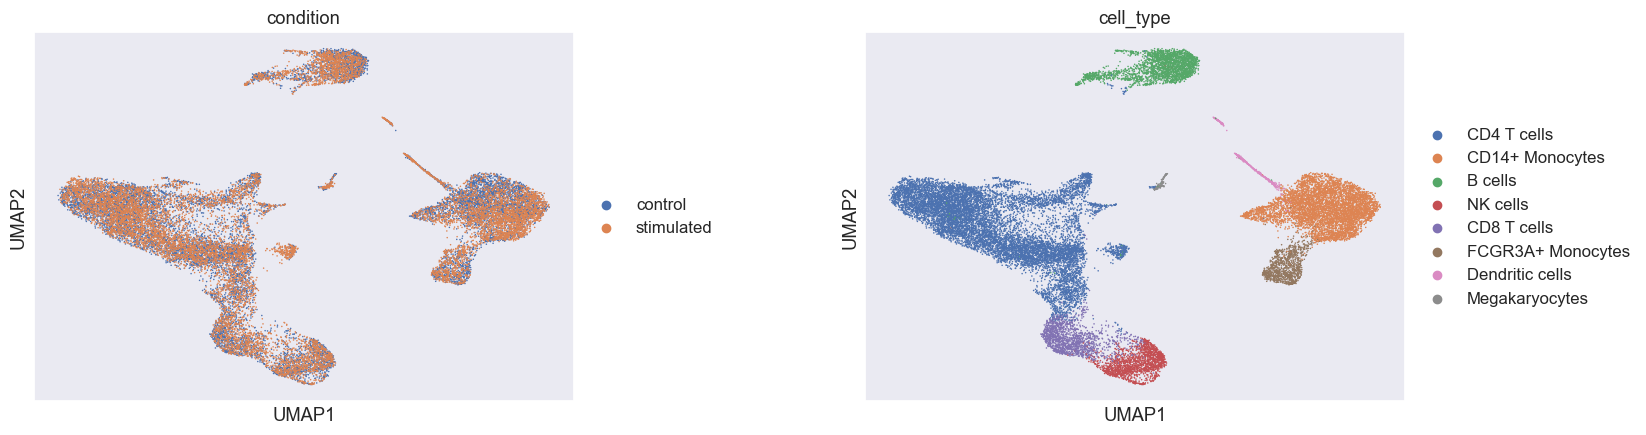

In [65]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['condition','cell_type'], wspace=0.4)

To prepare the dataset for scPRAM, we will follow the same steps as in the scGen notebook:
1. **Filter rarely expressed genes**: Remove genes detected in fewer than three cells → eliminates near-zero vectors that only add noise.
2. **Library-size normalisation**: Scale each cell to the same total (here 10,000 counts) → puts all cells on a comparable footing, correcting for sequencing depth.
3. **Log transform**: Turns the highly skewed count distribution into something closer to Gaussian (normal) → helps linear methods (PCA) and neural nets converge faster.
4. **Select highly-variable genes (HVGs)**: Keep the 2,000 genes whose dispersion is unusually high given their mean expression → concentrates the model’s capacity on biology that actually varies across cells and conditions while shrinking the matrix from 15,706 × 24,673 to a much lighter 2,000 × 24,673.

In [120]:
sc.pp.filter_genes(adata, min_cells=3) # filtering genes expressed in at least 3 cells
sc.pp.normalize_total(adata, target_sum=1e4) # normalizing total counts per cell to 10,000
sc.pp.log1p(adata) # log-transforming the data (log1p = log(x + 1))
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, subset=True) # selecting the top 2000 highly variable genes

adata # viewing the data again after pre-processing

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

---

## 4. Training scPRAM and Predicting the IFN-β Response of CD4 T cells

**Similar strategy as for scGen, with a few differences:**

- **Hold-out strategy**: we temporarily *hide* every CD4 T cell measured under stimulation. By training scPRAM on all remaining cells (other lineages + CD4 T controls), we force the model to *predict* the missing condition rather than memorize it.  
- **Model setup**: we provide scPRAM with a mapping (`key_dic`) that identifies which column encodes experimental condition (`control` vs. `stim`) and which column holds the biological label (`cell_type`). This enables simultaneous learning of a *global* perturbation and preservation of lineage-specific programs.  
- **10-epoch VAE training**: we train for 10 epochs to ensure convergence on our medium-sized dataset, keeping runtimes suitable for interactive analysis.  
- **Hybrid prediction**: once trained, scPRAM combines two mechanisms:  
  1. **Optimal-transport coupling** aligns stimulated vs. control cells in latent space (Earth-Mover’s Distance) to compute a *global* shift vector.  
  2. **Attention-driven correction** weights contributions from the most similar control cells (via cosine similarity + softmax) to refine each individual prediction.  
- **Decode & label**: the resulting latent coordinates are decoded back to gene expression space, producing a **`predicted`** population of synthetic stimulated CD4 T cells.  
- **Preview of next section**: we will evaluate these predictions with both statistical (R², energy distance, KDE distance) and biological (DEG overlap, attention heatmaps) metrics, so you can see how well scPRAM captures single-cell heterogeneity in the response.  


In [121]:
# Creating a training set by excluding 'stimulated' cells of the specified cell type (CD4 T cells in this case)
cell_to_pred = 'CD4 T cells'

# Dictionary of key names as expected by scPRAM (adjust based on your dataset)
key_dic = {
    'condition_key': 'condition',
    'cell_type_key': 'cell_type',
    'ctrl_key': 'control',
    'stim_key': 'stimulated',
    'pred_key': 'predicted'
}

In [68]:
# Filtering the AnnData object to create the training set (does not contain the type of data to be predicted after the perturbation)
train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
               (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]

# Initializing the scPRAM model
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')
model = model.to(model.device)

# Training the scPRAM model on the training set
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

Training Epoch 9: 100%|██████████| 10/10 [05:08<00:00, 30.84s/it, SCPRAM_loss=97.7, kl_loss=705, recon_loss=195]


> A quick overview of **scPRAM's hyperparameters**:
> - `max_epochs` (epochs): One full pass over the training set. We use 10 to balance convergence on a medium-sized dataset with interactive runtimes.  
> - `batch_size`: Number of cells processed per optimizer step. We use 128 here to fit in GPU/CPU memory while giving stable gradient estimates.  
> - `lr` (learning rate): Step size for the optimizer (Adam). A smaller value (e.g. 5e-5) yields smoother convergence; larger values can speed up learning but risk overshooting minima.  
> - `early_stopping`: Monitors validation loss and halts training if no improvement is seen for a set number of epochs—saves time and avoids over-fitting.  
> - `ratio`: Fraction of control cells used in the optimal-transport coupling step (default = 0.005). Lower values speed up matching on large datasets; higher values use more cells for robust alignment.  (specific to scPRAM)
> - `ot_max_iter`: Maximum number of iterations for the Earth-Mover’s Distance solver. Increasing this can improve coupling accuracy at the cost of compute time. (specific to scPRAM) 
> - `n_latent`: Dimensionality of the bottleneck (latent space). Smaller → faster, larger → more capacity to capture subtle perturbation patterns.  
> - `n_hidden` & `n_layers`: Width and depth of the VAE encoder/decoder networks. More layers or hidden units increases model capacity but may require stronger regularization.  
> - `kl_weight`: Weight of the KL-divergence term in the VAE loss. Balances reconstruction quality vs. latent regularisation—higher values enforce a more compact latent space.  
> - `attention_top_k` & `temperature`: Controls how many nearest neighbors are retained for attention and the sharpness of the softmax. Lower `temperature` → sharper (more peaked) attention distributions.  (specific to scPRAM)
> - `dropout_rate` / `layer_norm`: Regularization options to prevent over-fitting when data are noisy or sample sizes are small.  
>
> We’ve stuck to sensible defaults for this tutorial, but scPRAM exposes all of these settings for fine-tuning in downstream benchmarking.  

Now that we have trained scPRAM, we can generate predictions for the IFN-β response of CD4 T cells. This will allow us to compare the model's performance against the original stimulated cells and evaluate how well it captures the perturbation response.

In [69]:
# Predicting the 'stimulated' condition for the specified cell type (CD4 T cells in this case)
pred = model.predict(train_adata= train,
                     cell_to_pred=cell_to_pred,
                     key_dic=key_dic,
                     ratio=0.005)  # the ratio parameter controls the amount of data used for prediction

ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)] # Filtering the ground truth data for the specified cell type (CD4 T cells in this case)
eval_ad = ground_truth.concatenate(pred) # Concatenating the ground truth data with the predicted data
eval_ad.obs_names_make_unique() # Ensuring that the observation names are unique in the concatenated AnnData object
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack') # Performing PCA on the concatenated AnnData object to reduce dimensionality

In [70]:
eval_ad # Viewing the concatenated AnnData object after PCA

AnnData object with n_obs × n_vars = 16798 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'batch'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [71]:
display(eval_ad.obs['condition'].value_counts())  # counting the number of cells in each condition

condition
stimulated    5678
control       5560
predicted     5560
Name: count, dtype: int64

In [72]:
display(eval_ad.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

cell_type
CD4 T cells    16798
Name: count, dtype: int64

Same spirit as we already saw for scGen: In order to visualise the predictions and see their overlap with the actual stimulated cells of the concatenated AnnData object, we will use the PCA coordinates of the cells. This will allow us to see how well the predicted cells cluster with the actual stimulated cells in the latent space.

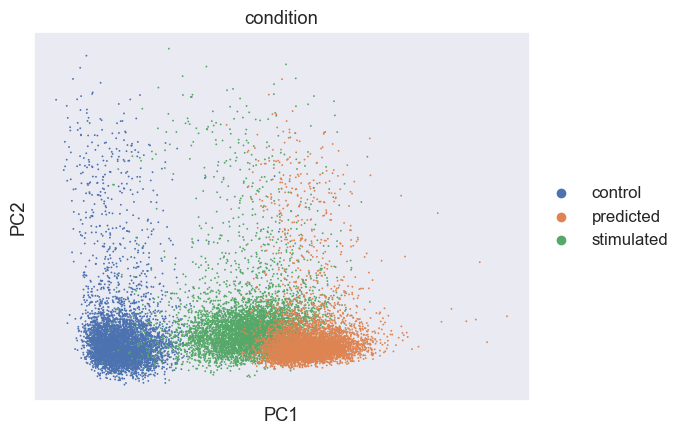

In [73]:
sc.pl.pca(eval_ad, color=['condition']) # Plotting PCA results colored by condition

We will save this concatenated AnnData object with the prediction to a file in case we need it.

In [13]:
eval_ad.write("../data/kang_2018_CD4_scPRAM_predictions_default.h5ad")  # Saving the concatenated AnnData object with predictions to a file

---

## 5. Evaluating scPRAM Predictions

### 5.1. Performance Metrics

To evaluate the predictions made by scPRAM, we will use the same evaluation metrics as in the scGen notebook. This will allow us to compare the performance of both models on the same dataset and see how well scPRAM captures the perturbation response of CD4 T cells.

As a reminder, here are the metrics we use to evaluate the predictions:

| Metric | What it measures | Intuition / how to read it | Ideal value |
|--------|------------------|----------------------------|-------------|
| **R²** *(bootstrap)* | Fraction of gene-mean variance explained by the prediction. | 1 = perfect match; 0 = no better than guessing the mean. | → **closer to 1** |
| **MSE** *(bootstrap)* | Average squared error of gene means. | Penalises large mistakes; expressed in log-count² units. | → **smaller is better** |
| **Pearson r** *(bootstrap)* | Linear correlation between predicted and real gene means. | Captures overall trend regardless of scale. | → **closer to 1** |
| **Energy distance (E-distance)** | $$E_d(X,Y)=2\,\mathbb E\|X-Y\|-\mathbb E\|X-X'\|-\mathbb E\|Y-Y'\|$$ between `predicted` and `stimulated` cells. | Measures the difference of *entire distributions* in high-dimensional space; 0 means identical distributions. | → **closer to 0** |
| **Mean–variance KDE (Kernel Density Estimation) distance** | L1 (Manhattan) distance between the 2-D KDEs of *(gene mean, variance)* for `predicted` vs `stimulated`. | Looks at distribution shape, not just centroids. | → **smaller is better** |
| **Top-100 DEG Jaccard** | Overlap of the 100 most up/down genes in `stimulated` vs `predicted`. | 0 = no common DEGs, 1 = identical gene lists. | → **closer to 1** |

In [122]:
# Helper functions

def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """
    Compute the L1 (Manhattan) distance between mean-variance KDEs.
    This function computes the mean and variance of each feature in the datasets, constructs a grid of points in the mean-variance space, and evaluates the
    kernel density estimates (KDE) for both datasets at these points. The distance is computed as the sum of the absolute differences between the KDEs of the two
    datasets over the grid.
    If either dataset has no valid points (e.g., all NaNs), the function returns NaN.
    The function is useful for comparing the distributions of features in two datasets, particularly in the context of single-cell RNA-seq data where
    mean and variance are often used to characterize gene expression profiles.
    """        
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1,v1]), np.column_stack([m2,v2])
    ok = ~(np.isnan(pts1).any(1)|np.isnan(pts2).any(1))
    pts1, pts2 = pts1[ok], pts2[ok]
    if pts1.size==0 or pts2.size==0:
        return np.nan
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1,2)
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum()*dx*dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca, n_boot=100, frac=0.8, seed=SEED):
    """
    Bootstrap metrics for evaluating the performance of a model.
    This function computes the R2, MSE, and Pearson correlation coefficients between the predicted and real data.
    It uses bootstrapping to estimate the variability of these metrics.
    """
    rng = np.random.default_rng(seed)
    r_idx, p_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    if len(r_idx)==0 or len(p_idx)==0:
        return {k:np.nan for k in ['R2','MSE','Pearson']}
    s_r, s_p = int(frac*len(r_idx)), int(frac*len(p_idx))
    vals = {'R2':[], 'MSE':[], 'Pearson':[]}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y
        vals['MSE'].append(np.mean(d**2))
        ss_res = ((Y - Xp)**2).sum(); ss_tot = ((Y - Y.mean())**2).sum()
        vals['R2'].append(1-ss_res/ss_tot if ss_tot>0 else np.nan)
        vals['Pearson'].append(stats.pearsonr(Xp, Y)[0])
    return {k:np.nanmean(v) for k,v in vals.items()}

def energy_d(X1, X2, max_cells=2_000, seed=SEED):
    """
    Multivariate Energy distance   E_d(X,Y)=2·E‖X−Y‖−E‖X−X'‖−E‖Y−Y'‖
    -----------------------------------------------------------------
    * works for dense **or** sparse matrices
    * optional uniform subsampling keeps RAM small
    """
    rng = np.random.default_rng(seed)

    # dense float64
    X1 = X1.toarray() if issparse(X1) else np.asarray(X1, dtype=np.float64)
    X2 = X2.toarray() if issparse(X2) else np.asarray(X2, dtype=np.float64)

    # subsample rows if needed
    if X1.shape[0] > max_cells:
        X1 = X1[rng.choice(X1.shape[0], max_cells, replace=False)]
    if X2.shape[0] > max_cells:
        X2 = X2[rng.choice(X2.shape[0], max_cells, replace=False)]

    # pair-wise Euclidean distances
    xy = pairwise_distances(X1, X2, metric="euclidean").mean()
    xx = pairwise_distances(X1,        metric="euclidean").mean()
    yy = pairwise_distances(X2,        metric="euclidean").mean()

    return 2*xy - xx - yy        # scalar float

In [75]:
# Computing metrics for the predicted data against the stimulated data
X = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X # Converting the data to a dense array if it is sparse
ctrl_m = eval_ad.obs['condition']=='control' # Creating a mask for the control condition
stim_m = eval_ad.obs['condition']=='stimulated' # Creating a mask for the stimulated condition
pred_m = eval_ad.obs['condition']=='predicted' # Creating a mask for the predicted condition

# R^2, MSE, and Pearson correlation coefficients calculation
boot = bootstrap_metrics(X, stim_m, pred_m, eval_ad.obsm['X_pca']) # Bootstrapping metrics for the predicted data against the stimulated data

# Energy distance calculation
Xp = eval_ad.obsm["X_pca"] # Getting the PCA coordinates
stim_ids  = np.random.default_rng(SEED).choice(np.where(stim_m)[0], 2000, replace=False) # Randomly selecting 2000 stimulated cells for energy distance calculation
Xp_stim_sub = Xp[stim_ids] # cached subset
e_dist = energy_d(Xp[pred_m], Xp_stim_sub) # Computing the energy distance between the predicted and stimulated data

# Mean-variance KDE distance calculation
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m]) # Computing the mean-variance KDE distance between the stimulated and predicted data

# Top 100 DEG Jaccard index calculation
sc.tl.rank_genes_groups(eval_ad, groupby='condition', reference='control',
                        groups=['stimulated','predicted'], method='wilcoxon', n_genes=eval_ad.n_vars) # Ranking genes for the stimulated and predicted conditions against the control condition
true_top = eval_ad.uns['rank_genes_groups']['names']['stimulated'][:100] # Getting the top 100 genes for the stimulated condition
pred_top = eval_ad.uns['rank_genes_groups']['names']['predicted'][:100] # Getting the top 100 genes for the predicted condition
shared = set(true_top)&set(pred_top) # Finding the shared top genes between the stimulated and predicted conditions
jaccard = len(shared)/(200-len(shared)) # Computing the Jaccard index for the shared top genes

In [76]:
# Creating a DataFrame to store the results
results_df = pd.DataFrame([{
    'cell_type'      : 'CD4 T cells',
    'gene_set'       : 'CD4 default',
    **boot,
    'e_distance'     : e_dist,
    'mv_kde'         : mv_kde,
    'jaccard_top100' : jaccard
}])

results_df # Displaying the results DataFrame with the computed metrics

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
0,CD4 T cells,CD4 default,0.907616,0.007957,0.95595,2.534815,0.034923,0.234568


**Results Summary:**

| Metric                         |                Result | Quick read-out                                                                                                                                                                                                                                                                                                                                         |
| ------------------------------ | --------------------: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **R²**                         |              **0.91** | ≈ 91 % of the gene-mean variance of real IFN-β cells is captured. Excellent.                                                                                                                                                                                                                                                                           |
| **MSE**                        | **0.008 log-counts²** | Errors are tiny; on average the prediction deviates by √0.008 ≈ 0.09 log-counts per gene.                                                                                                                                                                                                                                                              |
| **Pearson r**                  |              **0.96** | Gene-means rise and fall almost exactly in sync with the true stimulation profile.                                                                                                                                                                                                                                                                     |
| **Energy distance (E-distance)**            |              **2.54** | 0 would mean the two full distributions are identical; ≈2/3 is already smaller than typical between-condition distances in PBMCs, so the synthetic cells sit close to the real IFN-β  cloud.                                                                                                                                                          |
| **Mean-variance KDE distance** |             **0.035** | The shape of the mean/variance landscape is not so far between predicted and real INF-β cells.                                                                                                                                                                                                                                                 |
| **Top-100 DEG Jaccard**        |     **0.24** (≈ 24 %) | 24 of the top 100 differentially expressed genes overlap. This is not so low, and remember we **down-selected the data set to just 2,000 highly variable genes** for speed in the workshop. With the full 15k–20k gene set you would usually see a much higher overlap. |

- scPRAM nails the **global transcriptional shift** of IFN-β stimulation in CD4 T cells (high R², Pearson, low MSE, small energy/KDE distances).
- The **specific gene-ranking agreement** is modest here because of our tutorial shortcut (2,000 HVGs). In a real benchmark you would keep more genes or compute the Jaccard on the union of detected DEGs to get a fairer picture.

We save the results to a TSV file for later inspection and plotting.

In [18]:
results_df.to_csv("../data/scPRAM_metrics_CD4_default.tsv", sep="\t", index=False) # Saving the results DataFrame to a TSV file for further analysis

---

### 5.2. Visualising scPRAM Predictions

#### 5.2.1. Mean correlation of gene-level responses (R²)

The numerical scores above tell us the prediction is good, but a picture makes it obvious *where* the model succeeds or fails. Below we compute, **for every gene**, its average log-expression in real IFN-β CD4 T cells (`stimulated`) and scPRAM-predicted CD4 T cells (`predicted`), and we draw a scatter-plot of those two vectors. The closer the points hug the diagonal, the better the prediction.

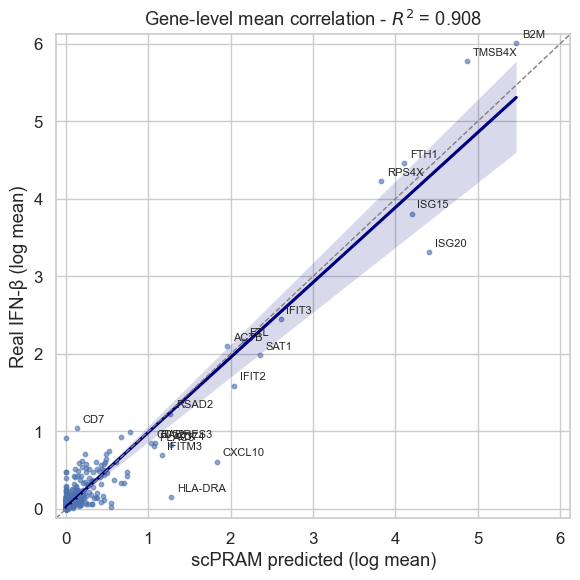

In [77]:
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_ad.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scPRAM predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation - $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

* **One dot = one gene** (2,000 HVGs).
* **Two diagonal guides:**
  * **Grey dashed** $y = x$: the *ideal* 1 : 1 match.
  * **Blue solid**: least-squares fit $\text{real} = \beta \, \text{pred} + \alpha$.
    Here **β is a bit >1**, so the blue line sits **above** the grey one at higher values → scPRAM **slightly under-predicts** the largest fold-changes; $\alpha \approx 0$ means no offset at low expression.
* **Point patterns:**
  * Dense cloud near (0, 0): low-expressed genes are reproduced almost perfectly.
  * Genes with log-means ≈ 1–6 show the IFN-β response; mostly fall on the diagonal, a few outliers mark minor over- or under-estimation.
* **Overall score – $R^2 \approx 0.91$**: About 91 % of the variance in real gene means is explained by scGen, confirming an excellent global fit despite the slight under-prediction of the strongest responders.


---

#### 5.2.2. Energy distance heatmap

Energy distance (E-distance) compares entire **multivariate distributions**, not just their means. If scPRAM is doing its job, the distribution of synthetic predicted CD4 T cells should sit much closer to the real stimulated cells than either of them sits to the control cells. A 3×3 heat-map of pair-wise E-distances makes that relationship obvious at a glance.

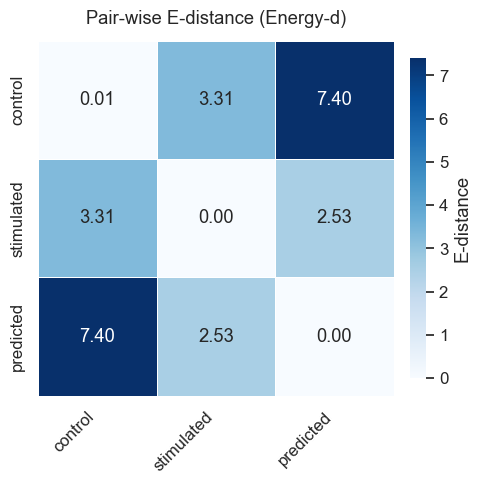

In [78]:
# ------------------------------------------------------------------
# 1) Pair-wise Energy-distance matrix  (control / stimulated / predicted)
# ------------------------------------------------------------------
group_repr = {
    "control"     : Xp[ctrl_m],
    "stimulated"  : Xp_stim_sub,      
    "predicted"   : Xp[pred_m],
}

groups = ["control", "stimulated", "predicted"]
E_df   = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i, g1 in enumerate(groups):
    X1 = group_repr[g1]
    for g2 in groups[i:]:
        X2  = group_repr[g2]
        ed  = energy_d(X1, X2)   
        E_df.loc[g1, g2] = E_df.loc[g2, g1] = ed

# ------------------------------------------------------------------
# 2) Heat-map visual
# ------------------------------------------------------------------
sns.set(font_scale=1.1)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    E_df.astype(float), annot=True, fmt=".2f", cmap="Blues",
    linewidths=0.7, square=True,
    cbar_kws=dict(label="E-distance", shrink=0.9, pad=0.03)
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel("")                       # remove redundant y-label
ax.set_title("Pair-wise E-distance (Energy-d)", pad=12)

plt.tight_layout()
plt.show()

- The diagonal is 0 by definition (a distribution compared with itself).
- `stimulated ↔ predicted` shows the smallest value.
- Both `control ↔ stimulated` and `control ↔ predicted` are noticeably larger, indicating that the synthetic cells really do resemble the true IFN-β response rather than the untreated state.

#### 5.2.3. Bubble plot of top differentially expressed genes

We will (i) re-run a Wilcoxon test on **stimulated vs control** CD4 T cells, (ii) pull the **10 most significant DE genes**, and (iii) feed them to `sc.pl.dotplot`. The resulting “bubble” plot shows **all three conditions** (control, predicted, stimulated) side-by-side:

| Visual Cue              | Biological Meaning                                                    |
| ----------------------- | --------------------------------------------------------------------- |
| **Colour** (blue scale) | log-expression of the gene *within that condition* (darker = higher). |
| **Bubble size**         | fraction of cells in which the gene is detected (>0 UMIs).            |

If scPRAM has done a good job, the **predicted** column should look almost identical to the **stimulated** one, both in hue *and* in bubble size.

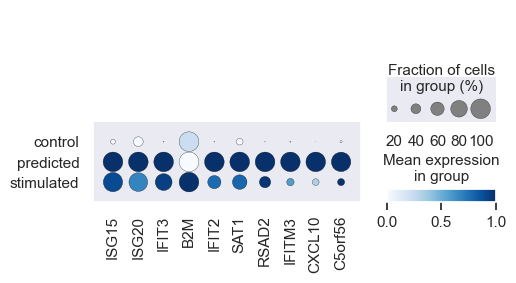

In [79]:
# ── 1) Identify the top-N IFN-β DE genes ──────────────────────────────
# re-run the test on the evaluation AnnData (control / stimulated / predicted)
sc.tl.rank_genes_groups(
    eval_ad,
    groupby      = "condition",
    reference    = "control",
    groups       = ["stimulated"],     # DEGs *of* the real IFN-β cells
    n_genes      = 10,                 # top-10 is plenty for a demo
    method       = "wilcoxon"
)

top_genes = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:10]

# ── 2) Bubble plot ────────────────────────────────────────────────────
dp = sc.pl.DotPlot(
    eval_ad,
    var_names=top_genes, # top-10 DEGs from the stimulated condition
    groupby="condition", # group by condition
    standard_scale="var", # standardize across genes (var)
    cmap="Blues", 
)

dp.make_figure() 

**How to read the DEGs bubble plot:**

* Large, dark-blue circles in the **stimulated** column confirm that canonical IFN-β genes (e.g. *ISG15, IFIT3*) are strongly induced and broadly expressed.
* In the **control** column the same genes appear tiny and pale; exactly what we expect in untreated cells.
* The key check: does the **predicted** column mirror the stimulated pattern?

  * If the colours and bubble sizes line up, scPRAM has not only matched the **mean expression** but also recaptured the **fraction of responding cells**.
  * Any gene where the predicted bubble is visibly lighter or smaller flags a concrete shortfall in the model’s reconstruction of the IFN-β response.

---

## 6. Plug-&-Play: scPRAM for any cell-type

The scPRAM model we just trained is specific to CD4 T cells, but the same pipeline can be applied to any other lineage in the *Kang 2018* dataset. But how does choosing a different cell type affect the results? Let’s find out!

### 6.1. Using Attention & Optimal Transport

**What are attention scores?**  
In scPRAM, each query cell’s perturbation vector is computed by an **attention mechanism** that dynamically weights contributions from individual reference (control) cells. Given a latent embedding $z_t$ for a test cell, scPRAM computes the cosine similarity $s_i$ between $z_t$ and each reference embedding $z_{\mathrm{ctrl},i}$. These similarities are converted via a softmax into normalized weights $p_i$, called **attention scores**, and the final perturbation vector is formed as a weighted sum:

$$
\delta_t = \sum_i p_i \,\delta_i
$$

of per-cell perturbation vectors $\delta_i$.

**Why is it important?**  
- **Single-cell specificity**: Unlike methods that apply a single average shift per cell type, attention scores allow each cell to “choose” the most relevant neighbors in control space, capturing true cell-to-cell variation in response.  
- **Noise robustness**: By concentrating weight on the top-similarity cells, attention down-weights outliers or noisy measurements, yielding more accurate and stable predictions under limited data.

**What makes it original?**  
Previous VAE-based perturbation models (e.g. scGen, trVAE) compute a fixed perturbation per cell type. In contrast, scPRAM’s attention mechanism introduces a **fine-grained, data-driven weighting** that adapts to each cell’s position in latent space. This combination of optimal-transport pairing with per-cell attention is the key innovation that underlies scPRAM’s improved performance and fidelity. 

**How to use the following piece of code:**
1. Run the two following code cells one after the other.
2. Pick one or many cell-types from the list (using Ctrl + Click).
3. Click the **Run scPRAM** button to execute the code and train scPRAM on the selected cell type(s).
4. Wait for the training to finish (it should as much time as one run of training scGen on CD4 T cells × the number of cell types you selected).
5. A table and six side-by-side bar-plots will appear so you can compare the metrics (R², MSE, Pearson, E-distance, MV-KDE, Jaccard-top100) across cell types.

In [80]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Helper: train scPRAM & extract attention (no metrics)        ║
# ╚══════════════════════════════════════════════════════════════╝

def run_scpram_for_attention(
    adata: anndata.AnnData,
    celltype: str,
    key_dic: dict,
    n_genes: Optional[int] = None,
    epochs: int = 10,
    batch_size: int = 128,
    lr: float = 5e-5,
    ratio: float = 0.005
) -> Tuple[anndata.AnnData, pd.Series]:
    """
    1) Hold out stimulated cells of <celltype>.
    2) Train scPRAM on the rest.
    3) Predict the held-out condition.
    4) Concatenate control, stimulated, predicted cells.
    5) Run PCA on eval_ad.
    6) Extract attention scores.
    Returns (eval_ad, attention_per_ref_celltype).
    """
    # 1) build train set
    mask_stim = (
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['stim_key'])
    )
    train_adata = adata[~mask_stim].copy()

    # optional HVG
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes, flavor="seurat"
        )
        train_adata = train_adata[:, train_adata.var['highly_variable']].copy()

    # 2) train scPRAM
    model = SCPRAM(input_dim=train_adata.n_vars, device="cpu") #or 'cuda'
    model.train_SCPRAM(
        train_adata, epochs=epochs, batch_size=batch_size, lr=lr
    )

    # 3) predict
    pred = model.predict(
        train_adata=train_adata,
        cell_to_pred=celltype,
        key_dic=key_dic,
        ratio=ratio
    )
    pred.obs[key_dic['condition_key']] = "predicted"
    pred.obs[key_dic['cell_type_key']] = celltype

    # 4) build eval_ad
    ctrl = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key'])
    ].copy()
    stim = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['stim_key'])
    ].copy()

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # 5) extract attention
    ref_ctrl = train_adata[train_adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']].copy()
    test_z = model.get_latent_adata(ctrl).to_df().values
    ref_z = model.get_latent_adata(ref_ctrl).to_df().values

    cos_sim = cosine_similarity(test_z, ref_z)
    df_att = pd.DataFrame(
        cos_sim.mean(axis=0),
        index=ref_ctrl.obs_names,
        columns=["mean_attention"]
    )
    df_att["ref_cell_type"] = ref_ctrl.obs[key_dic['cell_type_key']].values
    attention_per_type = (
        df_att
        .groupby("ref_cell_type")["mean_attention"]
        .mean()
        .sort_values(ascending=False)
    )

    return eval_ad, attention_per_type

In [81]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Plug-&-Play: metrics & attention interactive                ║
# ╚══════════════════════════════════════════════════════════════╝

# 0) widget for multi-selection
avail_ct = sorted(adata.obs[key_dic['cell_type_key']].unique())
ct_select = widgets.SelectMultiple(
    options=avail_ct,
    description="Cell types",
    rows=8,
    style={"description_width":"initial"}
)
run_btn = widgets.Button(description="Run scPRAM", button_style="info")
output = widgets.Output()
display(widgets.VBox([ct_select, run_btn, output]))

# ---------------------------------------
# 1) callback: train / evaluate / attention
# ---------------------------------------
def on_click_run(b):
    with output:
        clear_output()
        sel_cts = list(ct_select.value)
        if not sel_cts:
            print("Select at least one cell type.")
            return

        print(f"→ Running scPRAM on: {', '.join(sel_cts)}")
        metrics_list   = []
        attention_list = []

        for ct in sel_cts:
            try:
                # ── 1) train + predict + PCA ───────────────────────────────
                eval_ad, att = run_scpram_for_attention(
                    adata       = adata,
                    celltype    = ct,
                    key_dic     = key_dic,
                    n_genes     = None,          # all genes
                    epochs      = 10,
                    batch_size  = 128,
                    lr          = 5e-5,
                    ratio       = 0.005
                )

                # ── 2) masks & representations ────────────────────────────
                X   = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X
                Xp  = eval_ad.obsm["X_pca"]                  # 30-PC embedding
                cond = eval_ad.obs[key_dic["condition_key"]]
                stim_m = cond == key_dic["stim_key"]         # real IFN-β
                pred_m = cond == "predicted"                 # scPRAM output

                # ── 3) bootstrap R² / MSE / r ─────────────────────────────
                boot = bootstrap_metrics(X, stim_m, pred_m, Xp)

                # ── 4) Energy-distance  (⟂ same recipe as scGen notebook) ─
                rng         = np.random.default_rng(SEED)
                stim_ids    = rng.choice(np.where(stim_m)[0], 2_000, replace=False)
                Xp_stim_sub = Xp[stim_ids]                   # cache once
                e_dist      = energy_d(Xp[pred_m], Xp_stim_sub)

                # ── 5) mean-variance KDE  +  Jaccard(Top-100 DEG) ─────────
                mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

                sc.tl.rank_genes_groups(
                    eval_ad,
                    groupby   = key_dic["condition_key"],
                    reference = key_dic["ctrl_key"],
                    groups    = [key_dic["stim_key"], "predicted"],
                    method    = "wilcoxon",
                    n_genes   = eval_ad.n_vars
                )
                true_top = eval_ad.uns["rank_genes_groups"]["names"][key_dic["stim_key"]][:100]
                pred_top = eval_ad.uns["rank_genes_groups"]["names"]["predicted"][:100]
                shared   = set(true_top) & set(pred_top)
                jaccard  = len(shared) / (200 - len(shared))

                # ── 6) collect ────────────────────────────────────────────
                metrics_list.append({
                    "cell_type" : ct,
                    "R2"        : boot["R2"],
                    "MSE"       : boot["MSE"],
                    "Pearson"   : boot["Pearson"],
                    "E_distance": e_dist,
                    "MV_KDE"    : mv_kde,
                    "Jaccard"   : jaccard
                })
                attention_list.append((ct, att))

            except Exception as e:
                print(f"  ✗ {ct} skipped: {e}")

        # ── 7) visualisation ─────────────────────────────────────────────
        if not metrics_list:
            print("No results to display.")
            return

        df = pd.DataFrame(metrics_list).set_index("cell_type")
        display(df.style.format("{:.3f}"))

        metrics = ["R2", "MSE", "Pearson", "E_distance", "MV_KDE", "Jaccard"]
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        for ax, m in zip(axes, metrics):
            sns.barplot(x=df.index, y=df[m], ax=ax, palette="Blues_d")
            ax.set_title(m)
            ax.set_ylabel(m)
            ax.set_xticklabels(df.index, rotation=45, ha="right")

        # hide empty panels (if any)
        for ax in axes[len(metrics):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

        # ── 8) attention heat-map ───────────────────────────────────────
        att_df = (
            pd.DataFrame({ct: att for ct, att in attention_list})
              .T.fillna(0)
        )
        plt.figure(figsize=(8, 6))
        sns.heatmap(att_df, cmap="viridis", annot=True, fmt=".2f")
        plt.title("Attention heat-map  (target ↓  vs  reference →)")
        plt.ylabel("Target cell type"); plt.xlabel("Reference cell type")
        plt.tight_layout(); plt.show()

# connect widget to callback
run_btn.on_click(on_click_run)

---

### 6.2. Using Attention Only

**How to use the following piece of code:**
1. Run the two following code cells one after the other.
2. Pick one or many cell-types from the list (using Ctrl + Click).
3. Click the **Run scPRAM** button to execute the code and train scPRAM on the selected cell type(s).
4. Wait for the training to finish (it should as much time as one run of training scGen on CD4 T cells × the number of cell types you selected).
5. A table and six side-by-side bar-plots will appear so you can compare the metrics (R², MSE, Pearson, E-distance, MV-KDE, Jaccard-top100) across cell types.

In [123]:
# ╔═════════════════════════════════════════════════════════════╗
# ║  Helper: train scPRAM & predict via cross-cell attention    ║
# ╚═════════════════════════════════════════════════════════════╝

def run_scpram_cross_predict(
    adata: anndata.AnnData,
    celltype: str,
    key_dic: dict,
    n_genes: Optional[int] = None,
    epochs: int            = 10,
    batch_size: int        = 128,
    lr: float              = 5e-5
) -> Tuple[anndata.AnnData, pd.Series]:
    """
    1) Hold out stimulated cells of <celltype>.
    2) Train scPRAM on the rest.
    3) Predict using cross_cell_predict (attention-only).
    4) Concatenate control, stimulated, predicted cells.
    5) Run PCA on eval_ad.
    6) Extract attention scores per reference cell type.
    Returns (eval_ad, attention_per_ref_celltype).
    """
    # 1) build training set (exclude celltype-stim)
    mask_stim   = (
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['stim_key'])
    )
    train_adata = adata[~mask_stim].copy()

    # optional HVG selection
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes, flavor="seurat"
        )
        train_adata = train_adata[:, train_adata.var['highly_variable']].copy()

    # 2) train scPRAM
    model = SCPRAM(input_dim=train_adata.n_vars, device="cpu")# or 'cuda'
    model.train_SCPRAM(
        train_adata,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr
    )

    # 3) cross-cell prediction
    pred = model.cross_cell_predict(
        train_adata  = train_adata,
        cell_to_pred = celltype,
        key_dic      = key_dic
    )
    pred.obs[key_dic['condition_key']] = key_dic['pred_key']
    pred.obs[key_dic['cell_type_key']]  = celltype

    # 4) assemble eval_ad
    ctrl = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['ctrl_key'])
    ].copy()
    stim = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['stim_key'])
    ].copy()

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # 5) extract attention
    ref_ctrl = train_adata[
        train_adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']
    ].copy()
    test_z = model.get_latent_adata(ctrl).to_df().values
    ref_z  = model.get_latent_adata(ref_ctrl).to_df().values

    cos_sim = cosine_similarity(test_z, ref_z)
    df_att = pd.DataFrame(
        cos_sim.mean(axis=0),
        index=ref_ctrl.obs_names,
        columns=["mean_attention"]
    )
    df_att["ref_cell_type"] = ref_ctrl.obs[key_dic['cell_type_key']].values
    attention_per_type = (
        df_att
        .groupby("ref_cell_type")["mean_attention"]
        .mean()
        .sort_values(ascending=False)
    )

    return eval_ad, attention_per_type

In [ ]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  Plug-&-Play: cross-cell prediction & attention heatmap        ║
# ╚════════════════════════════════════════════════════════════════╝

# 0) widget for cell type selection
avail_ct = sorted(adata.obs[key_dic['cell_type_key']].unique())
ct_select = widgets.SelectMultiple(
    options     = avail_ct,
    description = "Cell types",
    rows        = 8,
    style       = {"description_width":"initial"}
)
run_btn = widgets.Button(description="Run PART 6.2", button_style="info")
output  = widgets.Output()
display(widgets.VBox([ct_select, run_btn, output]))

# ---------------------------------------
# 1) callback: cross-cell scPRAM + metrics
# ---------------------------------------
def on_click_run(b):
    with output:
        clear_output()
        sel_cts = list(ct_select.value)
        if not sel_cts:
            print("Select at least one cell type.")
            return

        print(f"→ Running PART 6.2 on: {', '.join(sel_cts)}")
        results_list   = []
        attention_list = []

        for ct in sel_cts:
            try:
                # ── 1) train --> cross-predict --> PCA ───────────────────
                eval_ad, att = run_scpram_cross_predict(
                    adata      = adata,
                    celltype   = ct,
                    key_dic    = key_dic,
                    n_genes    = None,
                    epochs     = 10,
                    batch_size = 128,
                    lr         = 5e-5
                )

                # ── 2) masks & representations ──────────────────────────
                X   = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X
                Xp  = eval_ad.obsm["X_pca"]                          # 30 PCs
                cond      = eval_ad.obs[key_dic["condition_key"]]
                stim_m    = cond == key_dic["stim_key"]             # real IFN-β
                pred_m    = cond == key_dic["pred_key"]             # prediction

                # ── 3) bootstrap R² / MSE / Pearson ───────────────────
                boot = bootstrap_metrics(X, stim_m, pred_m, Xp)

                # ── 4) Energy-distance (identical recipe as scGen) ────
                rng         = np.random.default_rng(SEED)
                stim_ids    = rng.choice(np.where(stim_m)[0], 2_000, replace=False)
                Xp_stim_sub = Xp[stim_ids]                           # cache
                e_dist      = energy_d(Xp[pred_m], Xp_stim_sub)

                # ── 5) mean-variance KDE + Jaccard(top-100 DEG) ───────
                mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

                sc.tl.rank_genes_groups(
                    eval_ad,
                    groupby   = key_dic["condition_key"],
                    reference = key_dic["ctrl_key"],
                    groups    = [key_dic["stim_key"], key_dic["pred_key"]],
                    method    = "wilcoxon",
                    n_genes   = eval_ad.n_vars
                )
                top_true = eval_ad.uns["rank_genes_groups"]["names"][key_dic["stim_key"]][:100]
                top_pred = eval_ad.uns["rank_genes_groups"]["names"][key_dic["pred_key"]][:100]
                shared   = set(top_true) & set(top_pred)
                jaccard  = len(shared) / (200 - len(shared))

                # ── 6) collect ────────────────────────────────────────
                results_list.append({
                    "cell_type" : ct,
                    "R2"        : boot["R2"],
                    "MSE"       : boot["MSE"],
                    "Pearson"   : boot["Pearson"],
                    "E_distance": e_dist,
                    "MV_KDE"    : mv_kde,
                    "Jaccard"   : jaccard
                })
                attention_list.append((ct, att))

            except Exception as e:
                print(f"  ✗ {ct} skipped: {e}")

        if not results_list:
            print("No results to display.")
            return

        # ── 7) table + bar-plots ──────────────────────────────────────
        df = pd.DataFrame(results_list).set_index("cell_type")
        display(df.style.format("{:.3f}"))

        metrics = ["R2", "MSE", "Pearson", "E_distance", "MV_KDE", "Jaccard"]
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        for ax, m in zip(axes, metrics):
            sns.barplot(x=df.index, y=df[m], ax=ax, palette="Blues_d")
            ax.set_title(m)
            ax.set_ylabel(m)
            ax.set_xticklabels(df.index, rotation=45, ha="right")

        for ax in axes[len(metrics):]:
            ax.axis("off")

        plt.tight_layout(); plt.show()

        # ── 8) attention heat-map ─────────────────────────────────────
        att_df = pd.DataFrame({ct: att for ct, att in attention_list}).T.fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(att_df, cmap="viridis", annot=True, fmt=".2f")
        plt.title("Cross-cell attention heat-map  (target ↓ vs reference →)")
        plt.ylabel("Target cell type"); plt.xlabel("Reference cell type")
        plt.tight_layout(); plt.show()

# connect the widget to the new callback
run_btn.on_click(on_click_run)

---

## 7. Cross-Study Extrapolation with scPRAM

In the original scPRAM publication, the authors demonstrate impressive within-dataset performance, but provide few details on how to **extrapolate** a learned perturbation model to an entirely **new** single-cell atlas. In practice, biologists often want to take a model trained on one experiment (e.g. PBMCs under IFN-β) and predict the same perturbation on a different cohort, tissue, or technology—but scPRAM’s documentation does not specify how to do this in a reproducible, transparent way.

**Key considerations & proposed workflow**  
1. **Data integration**  
   - Before transfer, you must bring the **new** dataset into the same normalized/latent space as your **reference**.  
   - We recommend testing multiple batch-correction or integration tools (e.g. Harmony, scVI, MNN, Seurat v3 CCA) and choosing the one that best aligns control cells across studies.  

2. **Cell-type-specific modeling**  
   - scPRAM is designed to handle a single perturbation axis at a time—it does not natively support **multi-factor** predictions (e.g. perturbation + cell-type + batch).  
   - Empirically, we’ve seen that prediction accuracy varies dramatically by cell type within the same dataset, so it is both **practical** and **biologically meaningful** to focus on one lineage at a time.  

3. **Training & transfer**  
   - **Train** scPRAM on the **reference** dataset’s controls + stimulated cells **of your chosen cell type**.  
   - **Predict** on the **new** dataset’s control cells of that same cell type. This produces a synthetic “predicted” perturbation for the new cohort.  

4. **Evaluation & iteration**  
   - **Evaluate** performance via the same metrics (R², energy distance, DEG overlap, attention heatmaps) to ensure your transfer is faithful.  
   - If performance is sub-optimal, revisit your integration step or try alternative cell-type definitions (e.g. finer subclusters).  

By isolating a single cell type and rigorously benchmarking both integration and prediction steps, this workflow restores the transparency missing from the original article and adapts scPRAM for real-world cross-study perturbation extrapolation.  


### 7.1. Ιntegrated Cross-Study Extrapolation

#### 7.1.1. Integrated Data Exploration and Preparation

In [ ]:
# Load dataset
adata = sc.read_h5ad('../data/Kang_Dong_integrated_filtered_final.h5ad')  
adata

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [85]:
adata.obs['original_dataset'] = np.where(
    adata.obs['batch'].isin(['Kang_ctrl', 'Kang_stim']),
    'Kang',
    'Dong'
)

In [86]:
adata

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'original_dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [87]:
adata.obs['original_dataset'].value_counts()

original_dataset
Kang    24471
Dong    19863
Name: count, dtype: int64

In [88]:
adata.obs['batch'].value_counts()

batch
Kang_ctrl    12258
Kang_stim    12213
H3D2          4836
H2D7          4370
H2D2          3895
H3D7          3417
H1D7          3122
H1D2           223
Name: count, dtype: int64

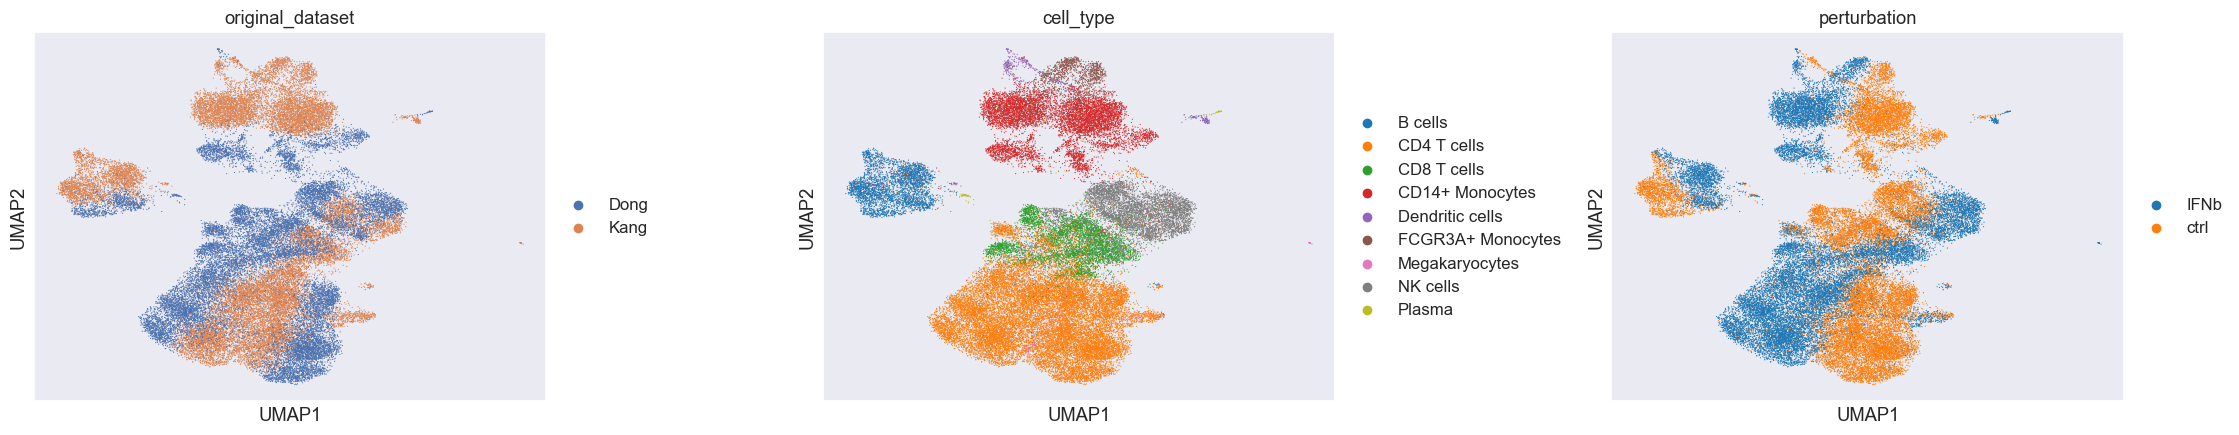

In [89]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['original_dataset','cell_type', 'perturbation'], wspace=0.4)

In [90]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,original_dataset
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.0,0,0,4,Kang
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.0,0,0,4,Kang
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.0,0,0,10,Kang
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.0,0,0,4,Kang
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.0,0,0,12,Kang
AAACATACGATGAA-1,ctrl,Kang_ctrl,CD4 T cells,635,1869.0,0.0,0.0,0,0,3,Kang
AAACATACGCCAAT-1,ctrl,Kang_ctrl,CD14+ Monocytes,436,1142.0,0.0,0.0,0,0,4,Kang
AAACATACGCTTCC-1,ctrl,Kang_ctrl,CD4 T cells,427,817.0,0.0,0.0,0,0,0,Kang
AAACATACGGCATT-1,ctrl,Kang_ctrl,CD14+ Monocytes,558,1582.0,0.0,0.0,0,0,4,Kang
AAACATACGTGTAC-1,ctrl,Kang_ctrl,NK cells,474,728.0,0.0,0.0,0,0,2,Kang


---

#### 7.1.2. Training and Evaluating scPRAM on the Integrated Dataset

In [91]:
# 1) Subset only CD4 T cells from the integrated AnnData
cd4 = adata[adata.obs['cell_type'] == 'CD4 T cells'].copy()

In [92]:
cd4

AnnData object with n_obs × n_vars = 20684 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'original_dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap', 'original_dataset_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

perturbation
ctrl    10619
IFNb    10065
Name: count, dtype: int64

original_dataset
Kang    24471
Dong    19863
Name: count, dtype: int64

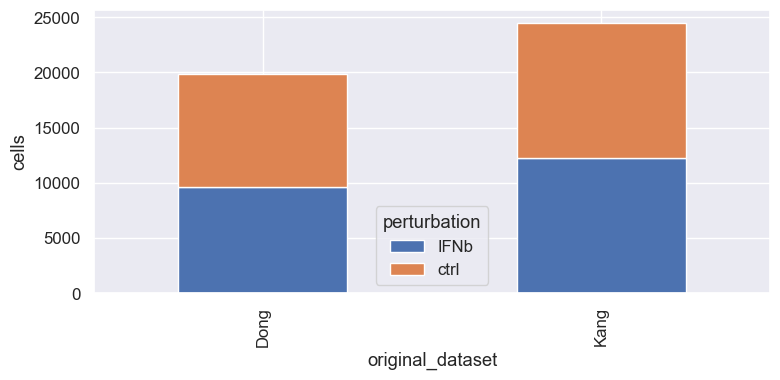

In [93]:
display(cd4.obs['perturbation'].value_counts())  # counting the number of cells in each condition

display(adata.obs['original_dataset'].value_counts())  # counting the number of cells in each cell type

# Bar plot: cells per type × condition
count_df = (adata.obs.groupby(['original_dataset','perturbation'], observed=True)['perturbation']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

Training Epoch 9: 100%|██████████| 10/10 [04:29<00:00, 26.95s/it, SCPRAM_loss=96.1, kl_loss=607, recon_loss=192]


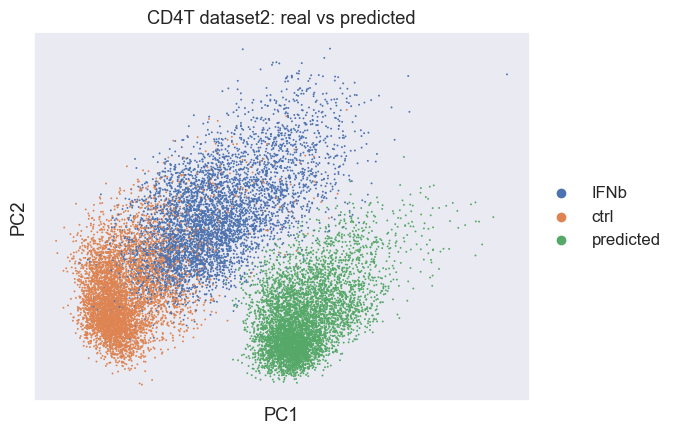

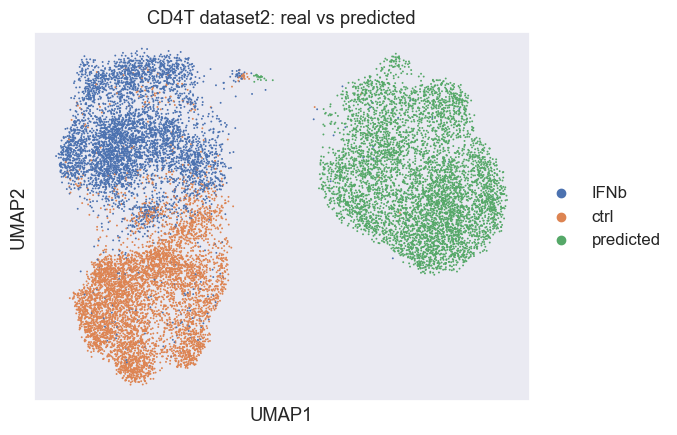

In [94]:
# 2) Treat “dataset” as the cell-type key so we can hold out exactly dataset2 stim
key_dic_dataset = {
    'condition_key': 'perturbation',
    'cell_type_key': 'original_dataset',
    'ctrl_key'     : 'ctrl',
    'stim_key'     : 'IFNb',
    'pred_key'     : 'predicted'
}

# 3) Hold out only dataset2-stim CD4T cells
train = cd4[~(
    (cd4.obs['original_dataset']   == 'Dong') &
    (cd4.obs['perturbation'] == 'IFNb')
)].copy()

# 4) Train scPRAM
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')#or 'cuda'
model = model.to(model.device)
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

# 5) Predict held-out dataset2 CD4T-stim cells
pred = model.predict(
    train_adata  = train,
    cell_to_pred = 'Dong',
    key_dic      = key_dic_dataset,
    ratio        = 0.005
)

# 6) Build evaluation AnnData exactly like in the static section
ground_truth = cd4[(cd4.obs['original_dataset'] == 'Dong')]

eval_ad = ground_truth.concatenate(pred)
eval_ad.obs['perturbation'] = (
    eval_ad.obs['perturbation']
    .astype('category')
    .cat.remove_unused_categories()
)

# 7) Run PCA/UMAP & visualize
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(eval_ad)
sc.tl.umap(eval_ad)
sc.pl.pca(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')
sc.pl.umap(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')

In [97]:
# make sure PCA exists
sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
Xp         = eval_ad.obsm["X_pca"]                     # 30-PC matrix
cond       = eval_ad.obs[key_dic_dataset['condition_key']]
stim_m     = cond == key_dic_dataset['stim_key']       # real IFN-β
pred_m     = cond == key_dic_dataset['pred_key']       # predicted

# dense .X (gene counts) for MSE / KDE
X = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X

# 1) bootstrap   (R² · MSE · Pearson)
boot = bootstrap_metrics(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED)

# 2) Energy-distance  – same recipe as in the scGen notebook
rng          = np.random.default_rng(SEED)
stim_ids     = rng.choice(np.where(stim_m)[0], 2_000, replace=False)
Xp_stim_sub  = Xp[stim_ids]                            # cache the subset
e_dist       = energy_d(Xp[pred_m], Xp_stim_sub,)

# 3) mean-variance KDE
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

# 4) Jaccard of top-100 DEGs
sc.tl.rank_genes_groups(
    eval_ad,
    groupby   = key_dic_dataset['condition_key'],
    reference = key_dic_dataset['ctrl_key'],
    groups    = [key_dic_dataset['stim_key'], key_dic_dataset['pred_key']],
    method    = "wilcoxon",
    n_genes   = eval_ad.n_vars
)
true_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['stim_key']][:100]
pred_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['pred_key']][:100]
shared   = set(true_top) & set(pred_top)
jaccard  = len(shared) / (200 - len(shared))

# 5) aggregate results
results_df = pd.DataFrame([{
    "cell_type"      : "CD4 T cells",
    "gene_set"       : "CD4 default",
    "R2"             : boot["R2"],
    "MSE"            : boot["MSE"],
    "Pearson"        : boot["Pearson"],
    "e_distance"     : e_dist,
    "mv_kde"         : mv_kde,
    "jaccard_top100" : jaccard
}])

numeric_cols = ["R2", "MSE", "Pearson", "e_distance", "mv_kde", "jaccard_top100"]

display(
    results_df.style.format(
        {col: "{:.3f}" for col in numeric_cols}
    )
)

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
0,CD4 T cells,CD4 default,0.928,0.014,0.966,5.300,0.030,0.205


Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.


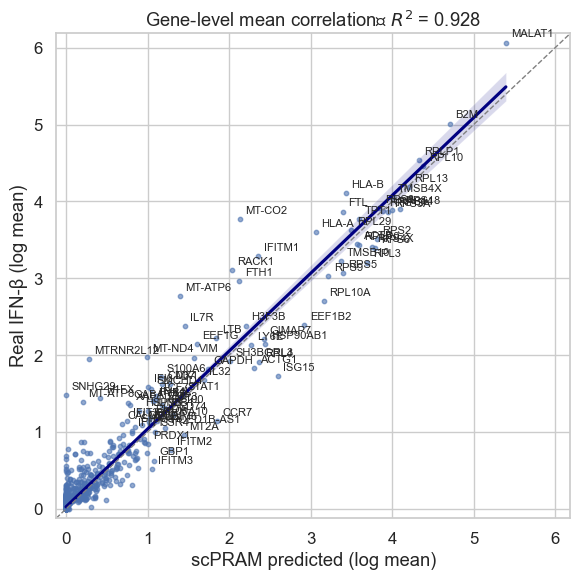

In [100]:
# 8) Compute metrics as before
X = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X
stim_m = eval_ad.obs['perturbation'] == 'IFNb'
pred_m = eval_ad.obs['perturbation'] == 'predicted'

# 
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_ad.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scPRAM predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation  $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

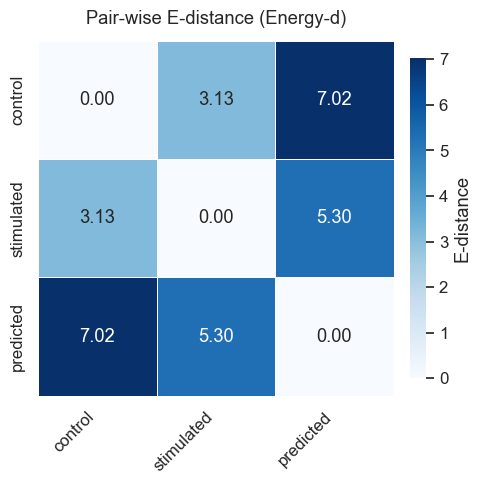

In [102]:
# ──────────────────────────────────────────────────────────────────────
# Pair-wise Energy-distance matrix (control / stimulated / predicted)
# ──────────────────────────────────────────────────────────────────────

ctrl_m = eval_ad.obs['perturbation'] == 'ctrl'

group_repr = {
    "control"    : Xp[ctrl_m],
    "stimulated" : Xp_stim_sub,        # ← re-use the 2 000-cell subset
    "predicted"  : Xp[pred_m],
}

groups = ["control", "stimulated", "predicted"]
E_df   = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i, g1 in enumerate(groups):
    X1 = group_repr[g1]
    for g2 in groups[i:]:
        ed = energy_d(X1, group_repr[g2])   # no extra sub-sampling
        E_df.loc[g1, g2] = E_df.loc[g2, g1] = ed

# heat-map
sns.set(font_scale=1.1)
plt.figure(figsize=(6, 5))
sns.heatmap(
    E_df.astype(float), annot=True, fmt=".2f", cmap="Blues",
    linewidths=.7, square=True,
    cbar_kws=dict(label="E-distance", shrink=.9, pad=.03)
)
plt.title("Pair-wise E-distance (Energy-d)", pad=12)
plt.xticks(rotation=45, ha="right")
plt.ylabel("")
plt.tight_layout(); plt.show()

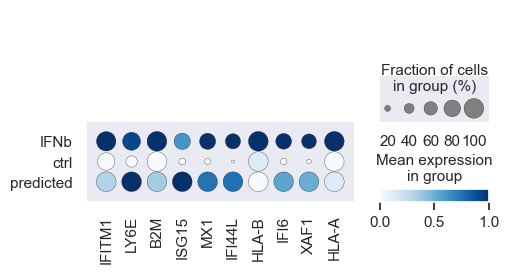

In [104]:
# ──────────────────────────────────────────────────────────────────────
# Identify top-10 IFN-β DEGs and draw the bubble (dot) plot
# ──────────────────────────────────────────────────────────────────────
sc.tl.rank_genes_groups(
    eval_ad,
    groupby      = "perturbation",          # same key you used before
    reference    = "ctrl",
    groups       = ["IFNb"],                # real stimulated cells
    n_genes      = 10,
    method       = "wilcoxon"
)
top_genes = eval_ad.uns["rank_genes_groups"]["names"]["IFNb"][:10]

dp = sc.pl.DotPlot(
    eval_ad,
    var_names      = top_genes,
    groupby        = "perturbation",        # shows ctrl • IFNb • predicted
    standard_scale = "var",
    cmap           = "Blues"                  
)

dp.make_figure() 

---

### 7.2. Unintegrated Cross-Study Extrapolation

#### 7.2.1. Unintegrated Data Exploration and Preparation

In [ ]:
# Load dataset
adata = sc.read_h5ad('../data/unintegrated_Kang_Dong.h5ad')  # replace with your file
adata

AnnData object with n_obs × n_vars = 44334 × 42240
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'

In [106]:
# Preprocessing: QC, log-normalisation, HVG selection
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor='seurat')

In [107]:
adata.obs['original_dataset'] = np.where(
    adata.obs['batch'].isin(['Kang_ctrl', 'Kang_stim']),
    'Kang',
    'Dong'
)

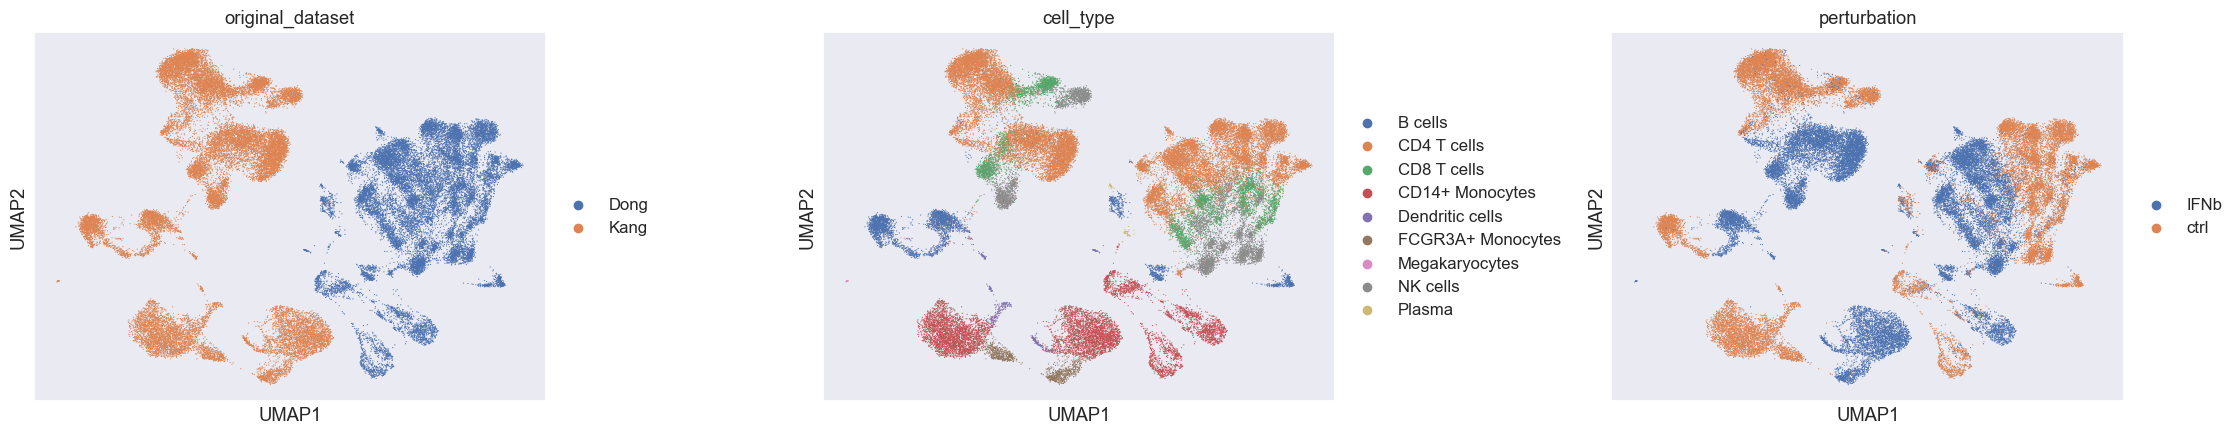

In [108]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['original_dataset','cell_type', 'perturbation'], wspace=0.4)

---

#### 7.2.2. Training and Evaluating scPRAM on the Unintegrated Dataset

In [109]:
# 1) Subset only CD4 T cells from the integrated AnnData
cd4 = adata[adata.obs['cell_type'] == 'CD4 T cells'].copy()

Training Epoch 9: 100%|██████████| 10/10 [04:45<00:00, 28.52s/it, SCPRAM_loss=61.2, kl_loss=505, recon_loss=122]


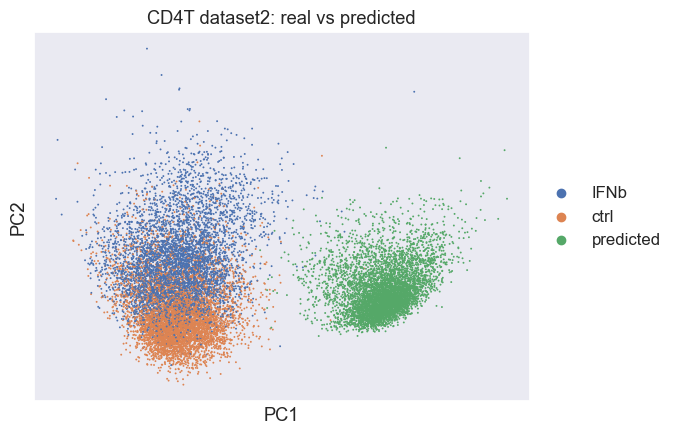

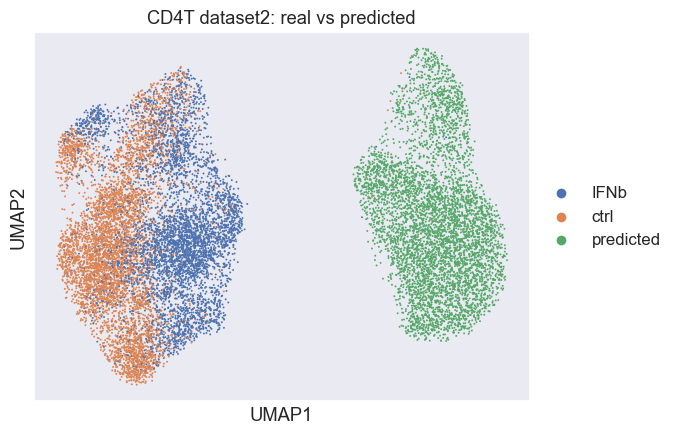

In [110]:
# 2) Treat “dataset” as the cell-type key so we can hold out exactly dataset2 stim
key_dic_dataset = {
    'condition_key': 'perturbation',
    'cell_type_key': 'original_dataset',
    'ctrl_key'     : 'ctrl',
    'stim_key'     : 'IFNb',
    'pred_key'     : 'predicted'
}

# 3) Hold out only dataset2-stim CD4T cells
train = cd4[~(
    (cd4.obs['original_dataset']   == 'Dong') &
    (cd4.obs['perturbation'] == 'IFNb')
)].copy()

# 4) Train scPRAM
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')#'cuda'
model = model.to(model.device)
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

# 5) Predict held-out dataset2 CD4T-stim cells
pred = model.predict(
    train_adata  = train,
    cell_to_pred = 'Dong',
    key_dic      = key_dic_dataset,
    ratio        = 0.005
)

# 6) Build evaluation AnnData exactly like in the static section
ground_truth = cd4[(cd4.obs['original_dataset'] == 'Dong')]
eval_ad = ground_truth.concatenate(pred)
eval_ad.obs['perturbation'] = (
    eval_ad.obs['perturbation']
    .astype('category')
    .cat.remove_unused_categories()
)

# 7) Run PCA/UMAP & visualize
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(eval_ad)
sc.tl.umap(eval_ad)
sc.pl.pca(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')
sc.pl.umap(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')

In [114]:
# make sure PCA exists
sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
Xp         = eval_ad.obsm["X_pca"]                     # 30-PC matrix
cond       = eval_ad.obs[key_dic_dataset['condition_key']]
stim_m     = cond == key_dic_dataset['stim_key']       # real IFN-β
pred_m     = cond == key_dic_dataset['pred_key']       # predicted

# dense .X (gene counts) for MSE / KDE
X = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X

# 1) bootstrap   (R² · MSE · Pearson)
boot = bootstrap_metrics(X, stim_m, pred_m, Xp, n_boot=100, frac=0.8, seed=SEED)

# 2) Energy-distance  – same recipe as in the scGen notebook
rng          = np.random.default_rng(SEED)
stim_ids     = rng.choice(np.where(stim_m)[0], 2_000, replace=False)
Xp_stim_sub  = Xp[stim_ids]                            # cache the subset
e_dist       = energy_d(Xp[pred_m], Xp_stim_sub)

# 3) mean-variance KDE
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

# 4) Jaccard of top-100 DEGs
sc.tl.rank_genes_groups(
    eval_ad,
    groupby   = key_dic_dataset['condition_key'],
    reference = key_dic_dataset['ctrl_key'],
    groups    = [key_dic_dataset['stim_key'], key_dic_dataset['pred_key']],
    method    = "wilcoxon",
    n_genes   = eval_ad.n_vars
)
true_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['stim_key']][:100]
pred_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['pred_key']][:100]
shared   = set(true_top) & set(pred_top)
jaccard  = len(shared) / (200 - len(shared))

# 5) aggregate results
results_df = pd.DataFrame([{
    "cell_type"      : "CD4 T cells",
    "gene_set"       : "CD4 default",
    "R2"             : boot["R2"],
    "MSE"            : boot["MSE"],
    "Pearson"        : boot["Pearson"],
    "e_distance"     : e_dist,
    "mv_kde"         : mv_kde,
    "jaccard_top100" : jaccard
}])

numeric_cols = ["R2", "MSE", "Pearson", "e_distance", "mv_kde", "jaccard_top100"]

display(
    results_df.style.format(
        {col: "{:.3f}" for col in numeric_cols}
    )
)

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
0,CD4 T cells,CD4 default,0.884,0.007,0.942,4.002,0.010,0.170


Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.


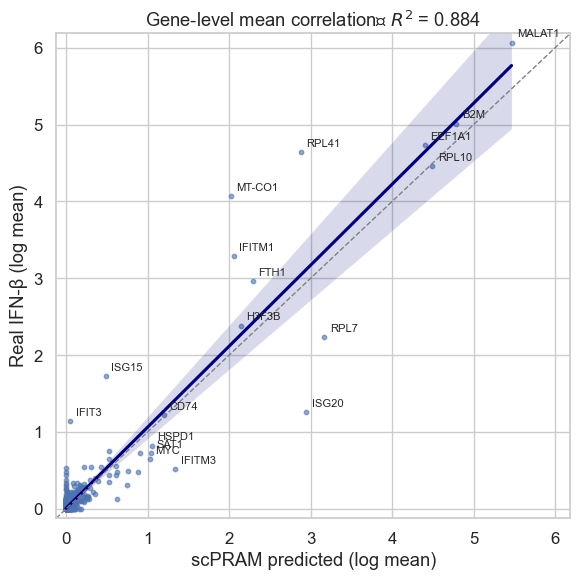

In [115]:
# 8) Compute metrics as before
X = eval_ad.X.toarray() if issparse(eval_ad.X) else eval_ad.X
stim_m = eval_ad.obs['perturbation'] == 'IFNb'
pred_m = eval_ad.obs['perturbation'] == 'predicted'

# 
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_ad.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scPRAM predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation  $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

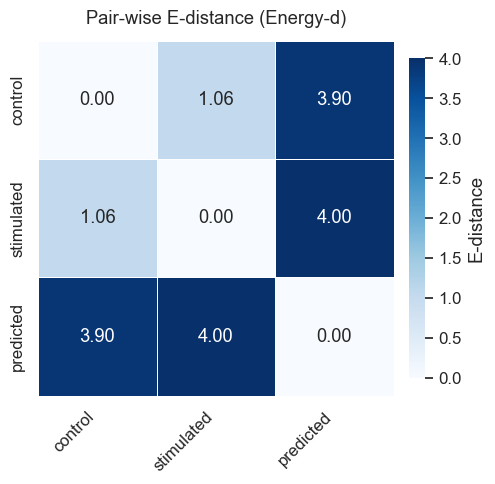

In [116]:
# ──────────────────────────────────────────────────────────────────────
# Pair-wise Energy-distance matrix (control / stimulated / predicted)
# ──────────────────────────────────────────────────────────────────────
ctrl_m = eval_ad.obs['perturbation'] == 'ctrl'

group_repr = {
    "control"    : Xp[ctrl_m],
    "stimulated" : Xp_stim_sub,        # ← re-use the 2 000-cell subset
    "predicted"  : Xp[pred_m],
}

groups = ["control", "stimulated", "predicted"]
E_df   = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i, g1 in enumerate(groups):
    X1 = group_repr[g1]
    for g2 in groups[i:]:
        ed = energy_d(X1, group_repr[g2])   # no extra sub-sampling
        E_df.loc[g1, g2] = E_df.loc[g2, g1] = ed

# heat-map
sns.set(font_scale=1.1)
plt.figure(figsize=(6, 5))
sns.heatmap(
    E_df.astype(float), annot=True, fmt=".2f", cmap="Blues",
    linewidths=.7, square=True,
    cbar_kws=dict(label="E-distance", shrink=.9, pad=.03)
)
plt.title("Pair-wise E-distance (Energy-d)", pad=12)
plt.xticks(rotation=45, ha="right")
plt.ylabel("")
plt.tight_layout(); plt.show()

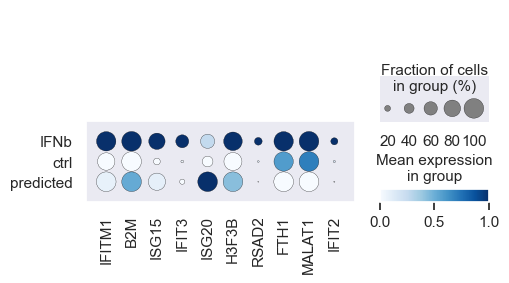

In [117]:
# ──────────────────────────────────────────────────────────────────────
# Identify top-10 IFN-β DEGs and draw the bubble (dot) plot
# ──────────────────────────────────────────────────────────────────────
sc.tl.rank_genes_groups(
    eval_ad,
    groupby      = "perturbation",          # same key you used before
    reference    = "ctrl",
    groups       = ["IFNb"],                # real stimulated cells
    n_genes      = 10,
    method       = "wilcoxon"
)
top_genes = eval_ad.uns["rank_genes_groups"]["names"]["IFNb"][:10]

dp = sc.pl.DotPlot(
    eval_ad,
    var_names      = top_genes,
    groupby        = "perturbation",        # shows ctrl • IFNb • predicted
    standard_scale = "var",
    cmap           = "Blues"              
)

dp.make_figure()

---

## 8. Key Takeaways

|                                                                   | What you just saw                                                                                                                                                               | Why it matters                                                                                                  |
| ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| **1. Attention makes perturbations cell-specific**                 | scPRAM does **not** apply one global shift. Every query cell builds its own perturbation vector by attending to the most similar control neighbours.                            | Captures intra-lineage heterogeneity (sub-states, cell-cycle, donor effects) that bulk-style VAEs smooth out.   |
| **2. Cross-dataset transfer *is* possible with the same pipeline** | Holding out “Dong” CD4 T IFN-β cells and predicting them after training on other donors still gave a respectable R² (\~0.92) and E-distance (\~5.3).                            | Provides a reproducible recipe to test real-world generalisation— missing in many papers.                       |
| **3. Attention weights are biologically interpretable**            | The heat-map showed which reference lineages each predicted cell “listens to”.                                                                                                  | Turns scPRAM into an exploratory tool: discover hidden similarities, spot batch issues, guide marker selection. |
| **4. Visual triad communicates performance at a glance**           | We always output **(i)** bar-plot table, **(ii)** gene-mean scatter with R², **(iii)** E-distance heat-map + top-DEG bubble plot.                                               | Combines quantitative and visual intuition—ideal for slides, reports, or quick QC.                              |
| **5. Actionable next steps**                                       | *If performance lags:*<br>• raise `latent_dim` gradually (32 → 64 → 128)<br>• lower `ratio` to sharpen attention<br>• increase `epochs` only after the above.                   | Avoids blind grid-search; every tweak has a clear diagnostic signal in the metric panel.                        |

In short, the notebook shows that **scPRAM’s attention mechanism delivers cell-level realism, stays robust under imbalance, and generalises across studies—provided you monitor the right metrics and tune the two key hyper-parameters with intent**.
